# Graph clustering method 
* SLIC for reducing the size of the graph with superpixel
* Spectral Clustering 
* Normalized cuts


In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, color, graph
from sklearn.cluster import SpectralClustering
from sklearn.feature_extraction import image
from networkx import to_scipy_sparse_array


c:\Users\HP\side project ml\computational_imaging\deepcut\venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\HP\side project ml\computational_imaging\deepcut\venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


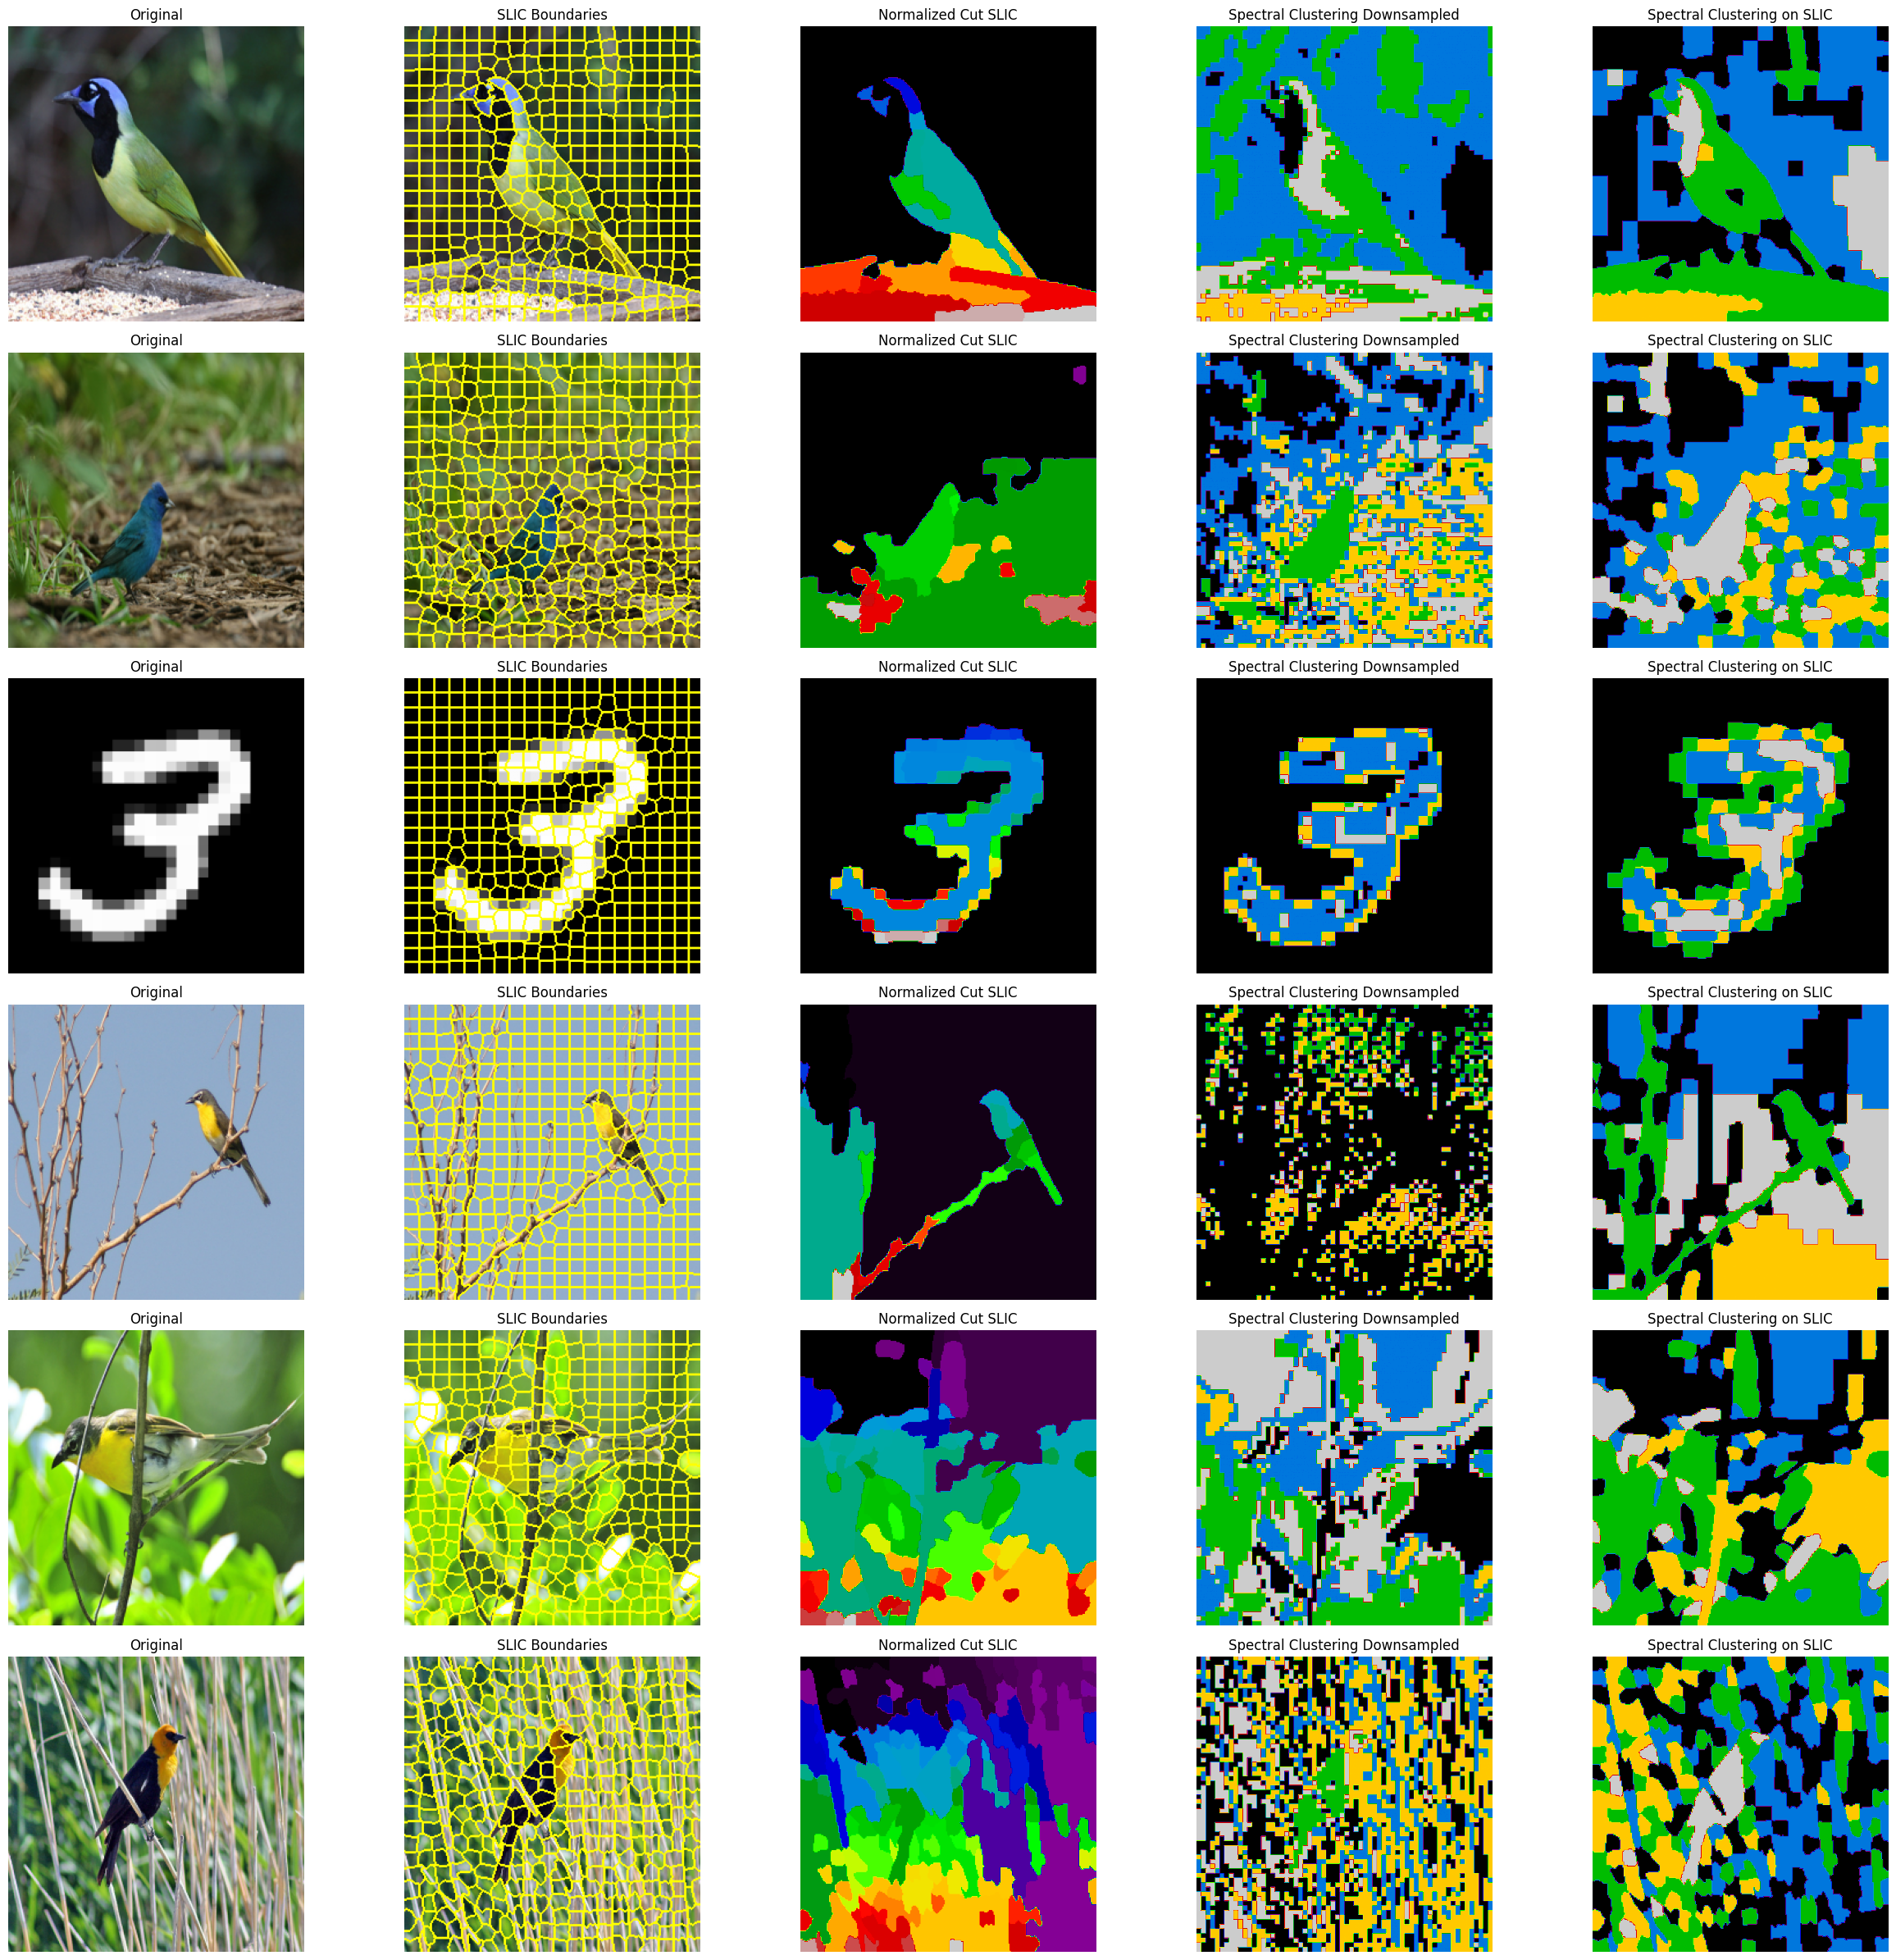

In [11]:

# Dossier contenant les images
image_folder  = os.path.join('DeepCutCompi','images', 'single' )

# Récupérer toutes les images
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Charger toutes les images dans une liste
images = [cv2.imread(os.path.join(image_folder, f)) for f in image_files]
fig, ax = plt.subplots(nrows=len(images), ncols=5, figsize=(25, 4*len(images)))

for k in range(len(images)):
    img = images[k]
    # Redimensionner pour uniformité
    res = (256, 256)
    img_resized = cv2.resize(img, res, interpolation=cv2.INTER_AREA)
    
    # Appliquer SLIC
    labels1 = segmentation.slic(img_resized, compactness=40, n_segments=400, sigma=1, start_label=1)
    
    # Appliquer Normalized Cut sur SLIC
    g = graph.rag_mean_color(img_resized, labels1, mode='similarity')
    labels2 = graph.cut_normalized(labels1, g)
    
    # 1. Appliquer Spectral Clustering sur l'image directement
    # Réduire la taille pour rendre le calcul plus rapide
    small_size = (64, 64)
    img_small = cv2.resize(img_resized, small_size, interpolation=cv2.INTER_AREA)
    
    # Convertir l'image en un tableau de pixels pour le clustering
    pixel_samples = np.reshape(img_small, (-1, 3))
    
    # Appliquer le spectral clustering
    n_clusters = 5  # Nombre de clusters à ajuster selon vos besoins
    spectral = SpectralClustering(n_clusters=n_clusters, 
                                 eigen_solver='arpack',
                                 affinity="nearest_neighbors",
                                 assign_labels="kmeans",
                                 random_state=42)
    
    # Réaliser le clustering
    spectral_labels = spectral.fit_predict(pixel_samples)
    
    # Reformater pour l'affichage
    segmented_img = np.reshape(spectral_labels, small_size)
    
    # Redimensionner au format original pour l'affichage
    segmented_img = cv2.resize(segmented_img.astype(float), res, 
                              interpolation=cv2.INTER_NEAREST)
    
    
    regions = {}
    for i in range(1, np.max(labels1) + 1):
        mask = labels1 == i
        if np.sum(mask) > 0:  # S'assurer que la région existe
            # Calculer la couleur moyenne de la région
            regions[i] = np.mean(img_resized[mask], axis=0)
    
    # Créer une matrice de caractéristiques pour le clustering
    n_regions = len(regions)
    region_features = np.zeros((n_regions, 3))  # 3 pour BGR
    region_indices = list(regions.keys())
    
    for i, region_idx in enumerate(region_indices):
        region_features[i] = regions[region_idx]
    
    # Appliquer le spectral clustering sur les régions SLIC
    # n_sc_clusters = min(n_regions // 5, 10)  # Adapter le nombre de clusters
    # if n_sc_clusters < 2:
    n_sc_clusters = 5  # Au moins 2 clusters
        
    spectral_slic = SpectralClustering(n_clusters=n_sc_clusters,
                                      eigen_solver='arpack',
                                      affinity="nearest_neighbors",
                                      assign_labels="kmeans",
                                      random_state=42)
    
    sc_slic_labels = spectral_slic.fit_predict(region_features)
    
    # Créer l'image segmentée finale
    sc_slic_segmented = np.zeros(labels1.shape, dtype=np.int32)
    for i, region_idx in enumerate(region_indices):
        sc_slic_segmented[labels1 == region_idx] = sc_slic_labels[i]
    
    # Affichage
    ax[k, 0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    ax[k, 0].set_title("Original")
    
    slic_boundaries = segmentation.mark_boundaries(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB), labels1)
    ax[k, 1].imshow(slic_boundaries)
    ax[k, 1].set_title("SLIC Boundaries")
    
    ax[k, 2].imshow(labels2, cmap='nipy_spectral')
    ax[k, 2].set_title("Normalized Cut SLIC")
    
    ax[k, 3].imshow(segmented_img, cmap='nipy_spectral')
    ax[k, 3].set_title("Spectral Clustering Downsampled")
    
    ax[k, 4].imshow(sc_slic_segmented, cmap='nipy_spectral')
    ax[k, 4].set_title("Spectral Clustering on SLIC")
    
    # Désactiver les axes
    for i in range(5):
        ax[k, i].axis('off')

plt.tight_layout()
plt.show()

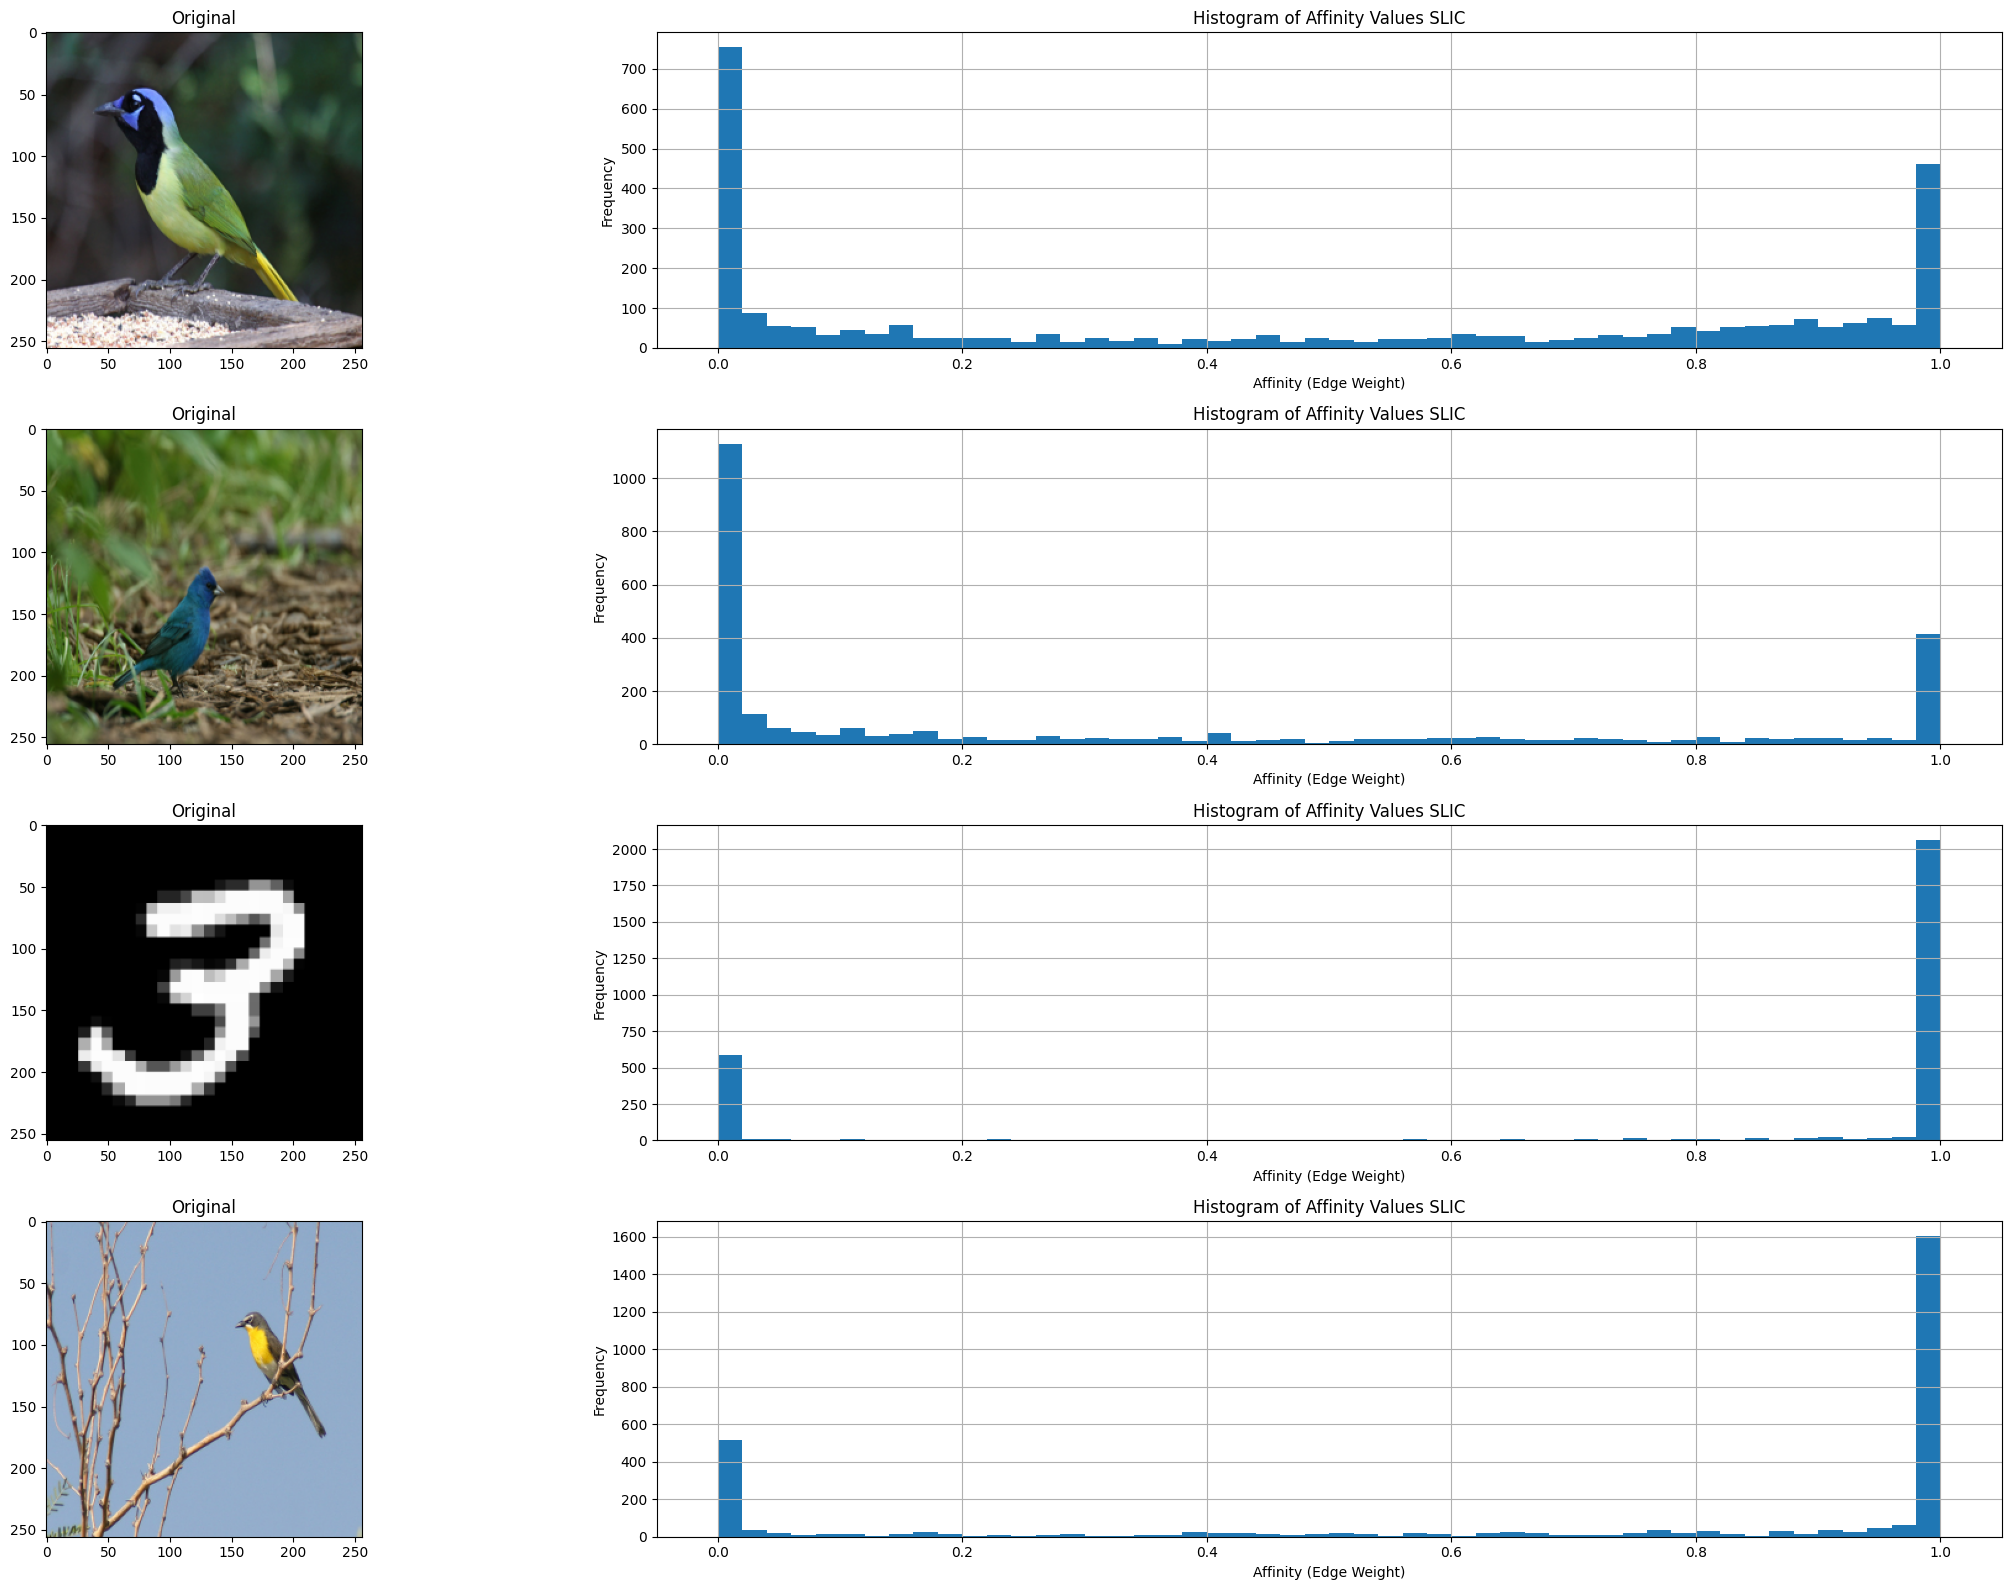

In [12]:
image_folder  = os.path.join('Deepcut','images', 'single' )

# Récupérer toutes les images
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Charger toutes les images dans une liste
images = [cv2.imread(os.path.join(image_folder, f)) for f in image_files]
fig, ax = plt.subplots( nrows=len(images),ncols=2, figsize=(25, 4*len(images)))
for k in range(len(images)):
    img = images[k]
    # Redimensionner pour uniformité
    res = (256, 256)
    img_resized = cv2.resize(img, res, interpolation=cv2.INTER_AREA)
    labels1 = segmentation.slic(img_resized, compactness=40, n_segments=400, sigma=1, start_label=1)
    
    # Appliquer Normalized Cut sur SLIC
    g = graph.rag_mean_color(img_resized, labels1, mode='similarity')
    labels2 = graph.cut_normalized(labels1, g)
    A_nx = to_scipy_sparse_array(g, weight='weight')
    affinities = A_nx.data  # This gives you all non-zero values (edge weights)

    
    ax[k, 0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    ax[k, 0].set_title("Original")
    ax[k,1].hist(affinities, bins=50)
    ax[k,1].set_title("Histogram of Affinity Values SLIC")
    ax[k,1].set_xlabel("Affinity (Edge Weight)")
    ax[k,1].set_ylabel("Frequency")
    ax[k,1].grid(True)
plt.tight_layout()
plt.show()

In [13]:
A_nx

<400x400 sparse array of type '<class 'numpy.float64'>'
	with 2940 stored elements in Compressed Sparse Row format>

In [14]:
A_dense = A_nx.todense()
print(A_dense)


[[1.         0.77108069 0.         ... 0.         0.         0.        ]
 [0.77108069 1.         0.99894546 ... 0.         0.         0.        ]
 [0.         0.99894546 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


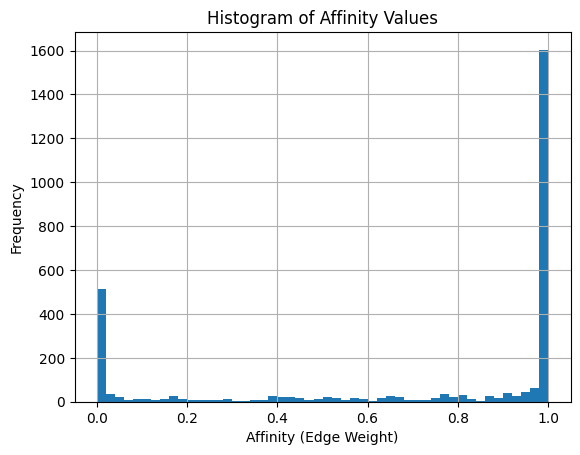

In [15]:
import matplotlib.pyplot as plt
affinities = A_nx.data  # This gives you all non-zero values (edge weights)

plt.hist(affinities, bins=50)
plt.title("Histogram of Affinity Values")
plt.xlabel("Affinity (Edge Weight)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

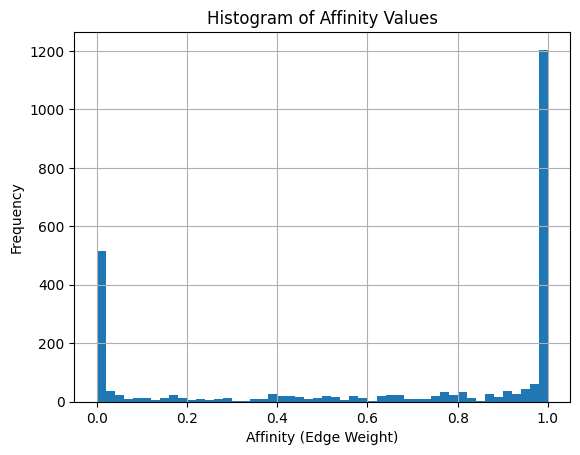

In [16]:
rag = graph.rag_mean_color(img_resized, labels1, mode='similarity')
from networkx import to_scipy_sparse_array

A_nx_rag = to_scipy_sparse_array(rag, weight='weight')
affinities = A_nx_rag.data  # This gives you all non-zero values (edge weights)

plt.hist(affinities, bins=50)
plt.title("Histogram of Affinity Values")
plt.xlabel("Affinity (Edge Weight)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

c:\Users\HP\side project ml\computational_imaging\deepcut\venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\HP\side project ml\computational_imaging\deepcut\venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


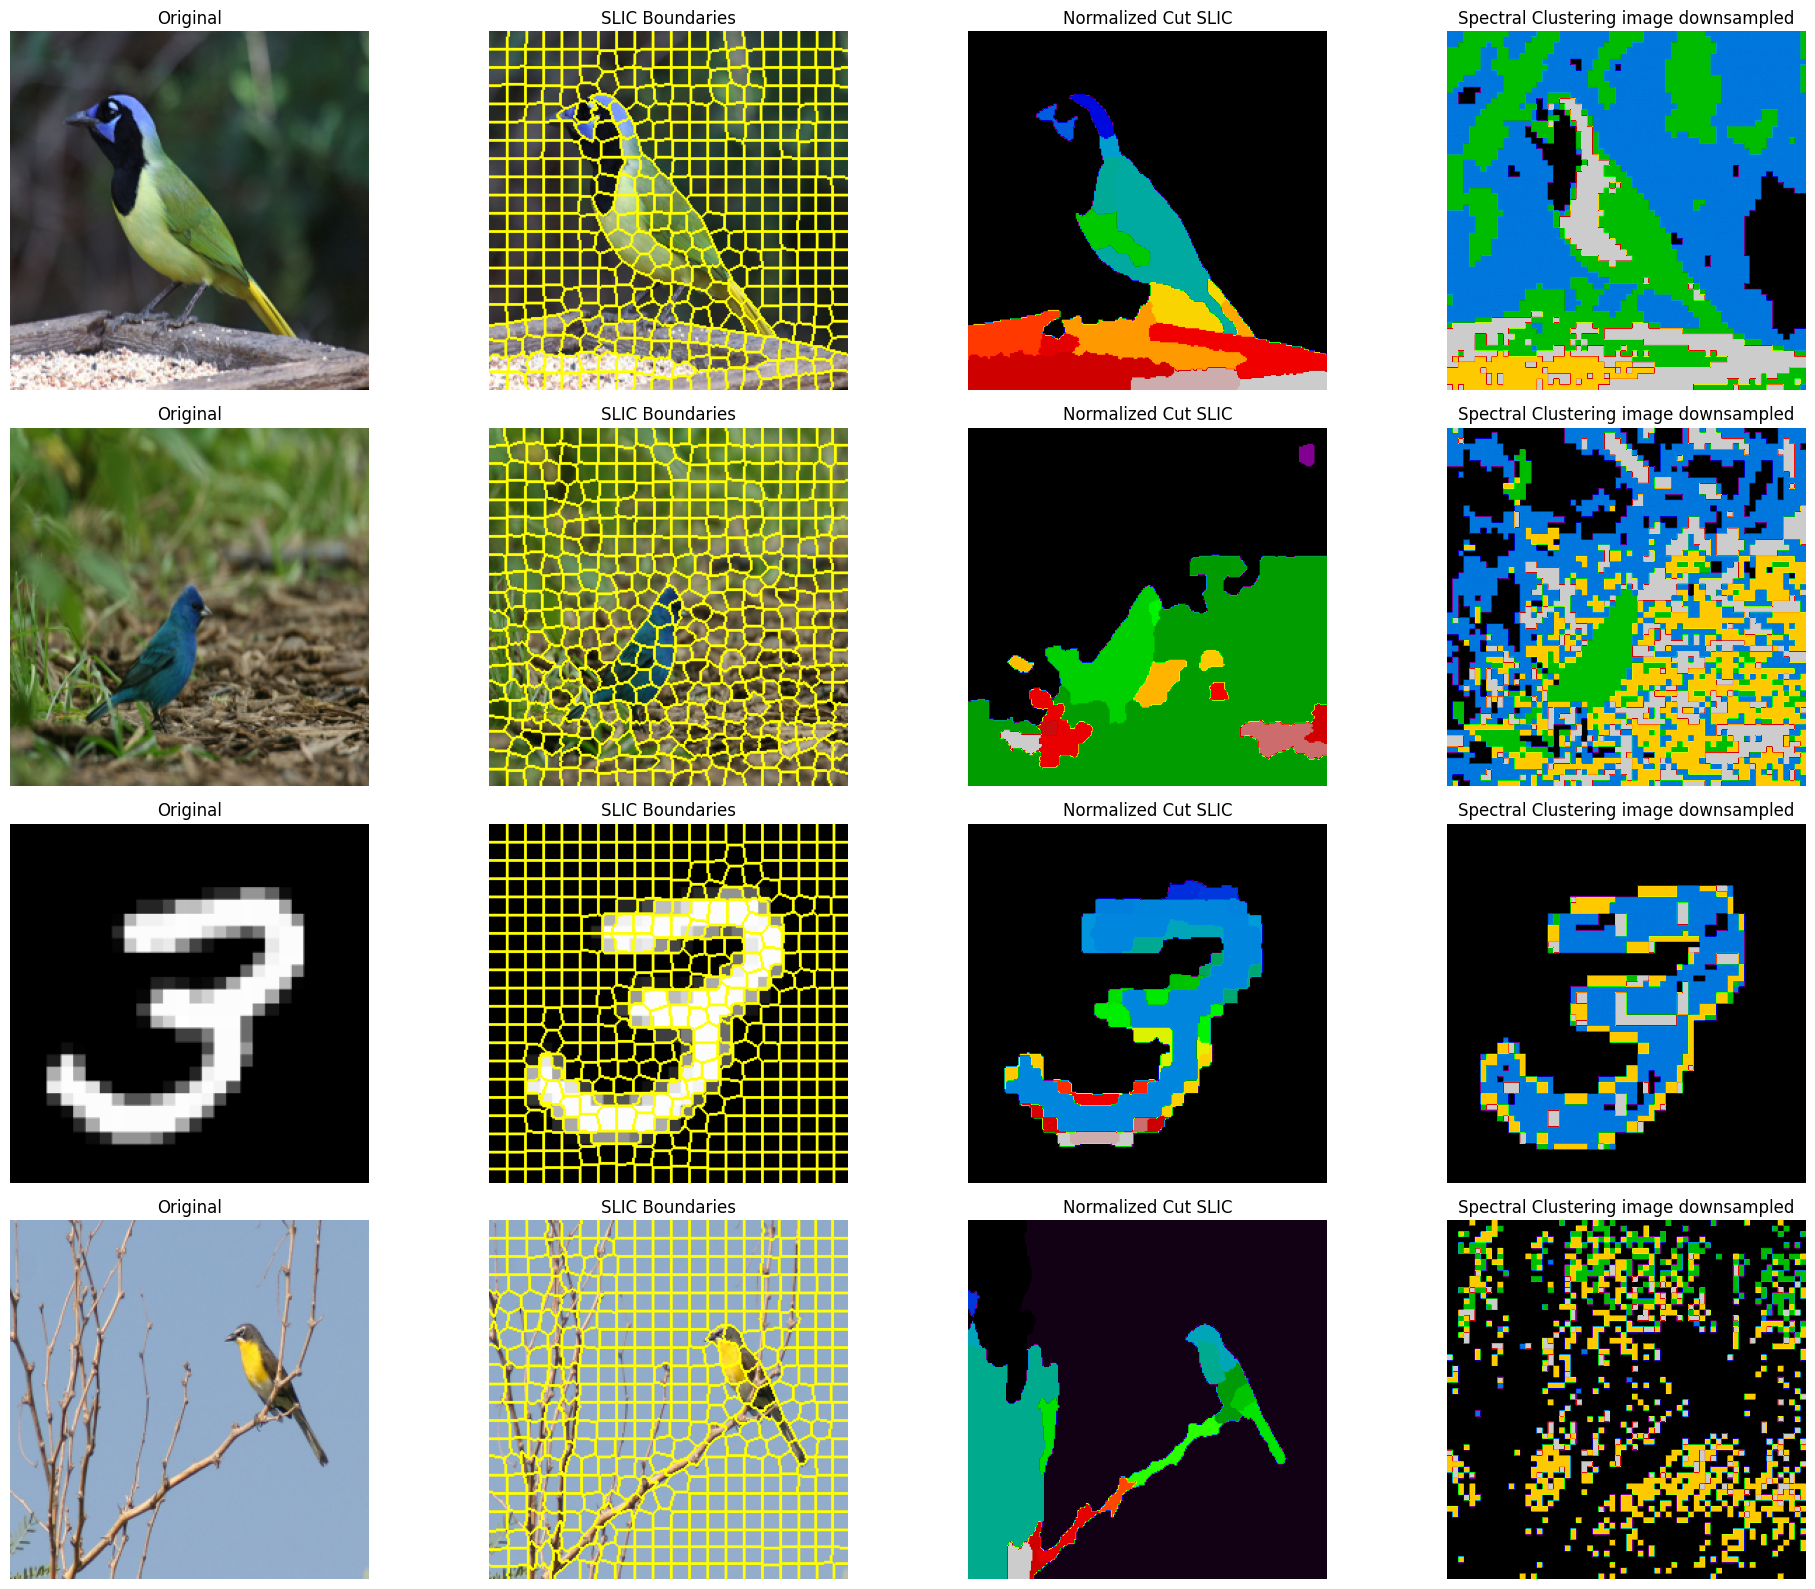

In [17]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, color, graph
from sklearn.cluster import SpectralClustering
from sklearn.feature_extraction import image

# Dossier contenant les images
image_folder  = os.path.join('Deepcut','images', 'single' )

# Récupérer toutes les images
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Load all images into a list
# Charger toutes les images dans une liste
images = [cv2.imread(os.path.join(image_folder, f)) for f in image_files]
fig, ax = plt.subplots(nrows=len(images), ncols=4, figsize=(20, 4*len(images)))

for k in range(len(images)):
    img = images[k]
    # Redimensionner pour uniformité
    res = (256, 256)
    img_resized = cv2.resize(img, res, interpolation=cv2.INTER_AREA)
    
    # Appliquer SLIC
    labels1 = segmentation.slic(img_resized, compactness=40, n_segments=400, sigma=1, start_label=1)
    
    # Appliquer Normalized Cut sur SLIC
    g = graph.rag_mean_color(img_resized, labels1, mode='similarity')
    labels2 = graph.cut_normalized(labels1, g)
    
    # Appliquer Spectral Clustering
    # Réduire la taille pour rendre le calcul plus rapide
    small_size = (64, 64)
    img_small = cv2.resize(img_resized, small_size, interpolation=cv2.INTER_AREA)
    
    # Convertir l'image en un tableau de pixels pour le clustering
    pixel_samples = np.reshape(img_small, (-1, 3))
    
    # Appliquer le spectral clustering
    n_clusters = 5  # Nombre de clusters à ajuster selon vos besoins
    spectral = SpectralClustering(n_clusters=n_clusters, 
                                 eigen_solver='arpack',
                                 affinity="nearest_neighbors",
                                 assign_labels="kmeans",
                                 random_state=42)
    
    # Réaliser le clustering
    spectral_labels = spectral.fit_predict(pixel_samples)
    
    # Reformater pour l'affichage
    segmented_img = np.reshape(spectral_labels, small_size)
    
    # Redimensionner au format original pour l'affichage
    segmented_img = cv2.resize(segmented_img.astype(float), res, 
                              interpolation=cv2.INTER_NEAREST)
    
    # Affichage
    ax[k, 0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    ax[k, 0].set_title("Original")
    
    slic_boundaries = segmentation.mark_boundaries(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB), labels1)
    ax[k, 1].imshow(slic_boundaries)
    ax[k, 1].set_title("SLIC Boundaries")
    
    ax[k, 2].imshow(labels2, cmap='nipy_spectral')
    ax[k, 2].set_title("Normalized Cut SLIC")
    
    ax[k, 3].imshow(segmented_img, cmap='nipy_spectral')
    ax[k, 3].set_title("Spectral Clustering image downsampled")
    
    # Désactiver les axes
    for i in range(4):
        ax[k, i].axis('off')

# Ajuster automatiquement l'espacement
plt.tight_layout()
plt.show()

c:\Users\HP\side project ml\computational_imaging\deepcut\venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\HP\side project ml\computational_imaging\deepcut\venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


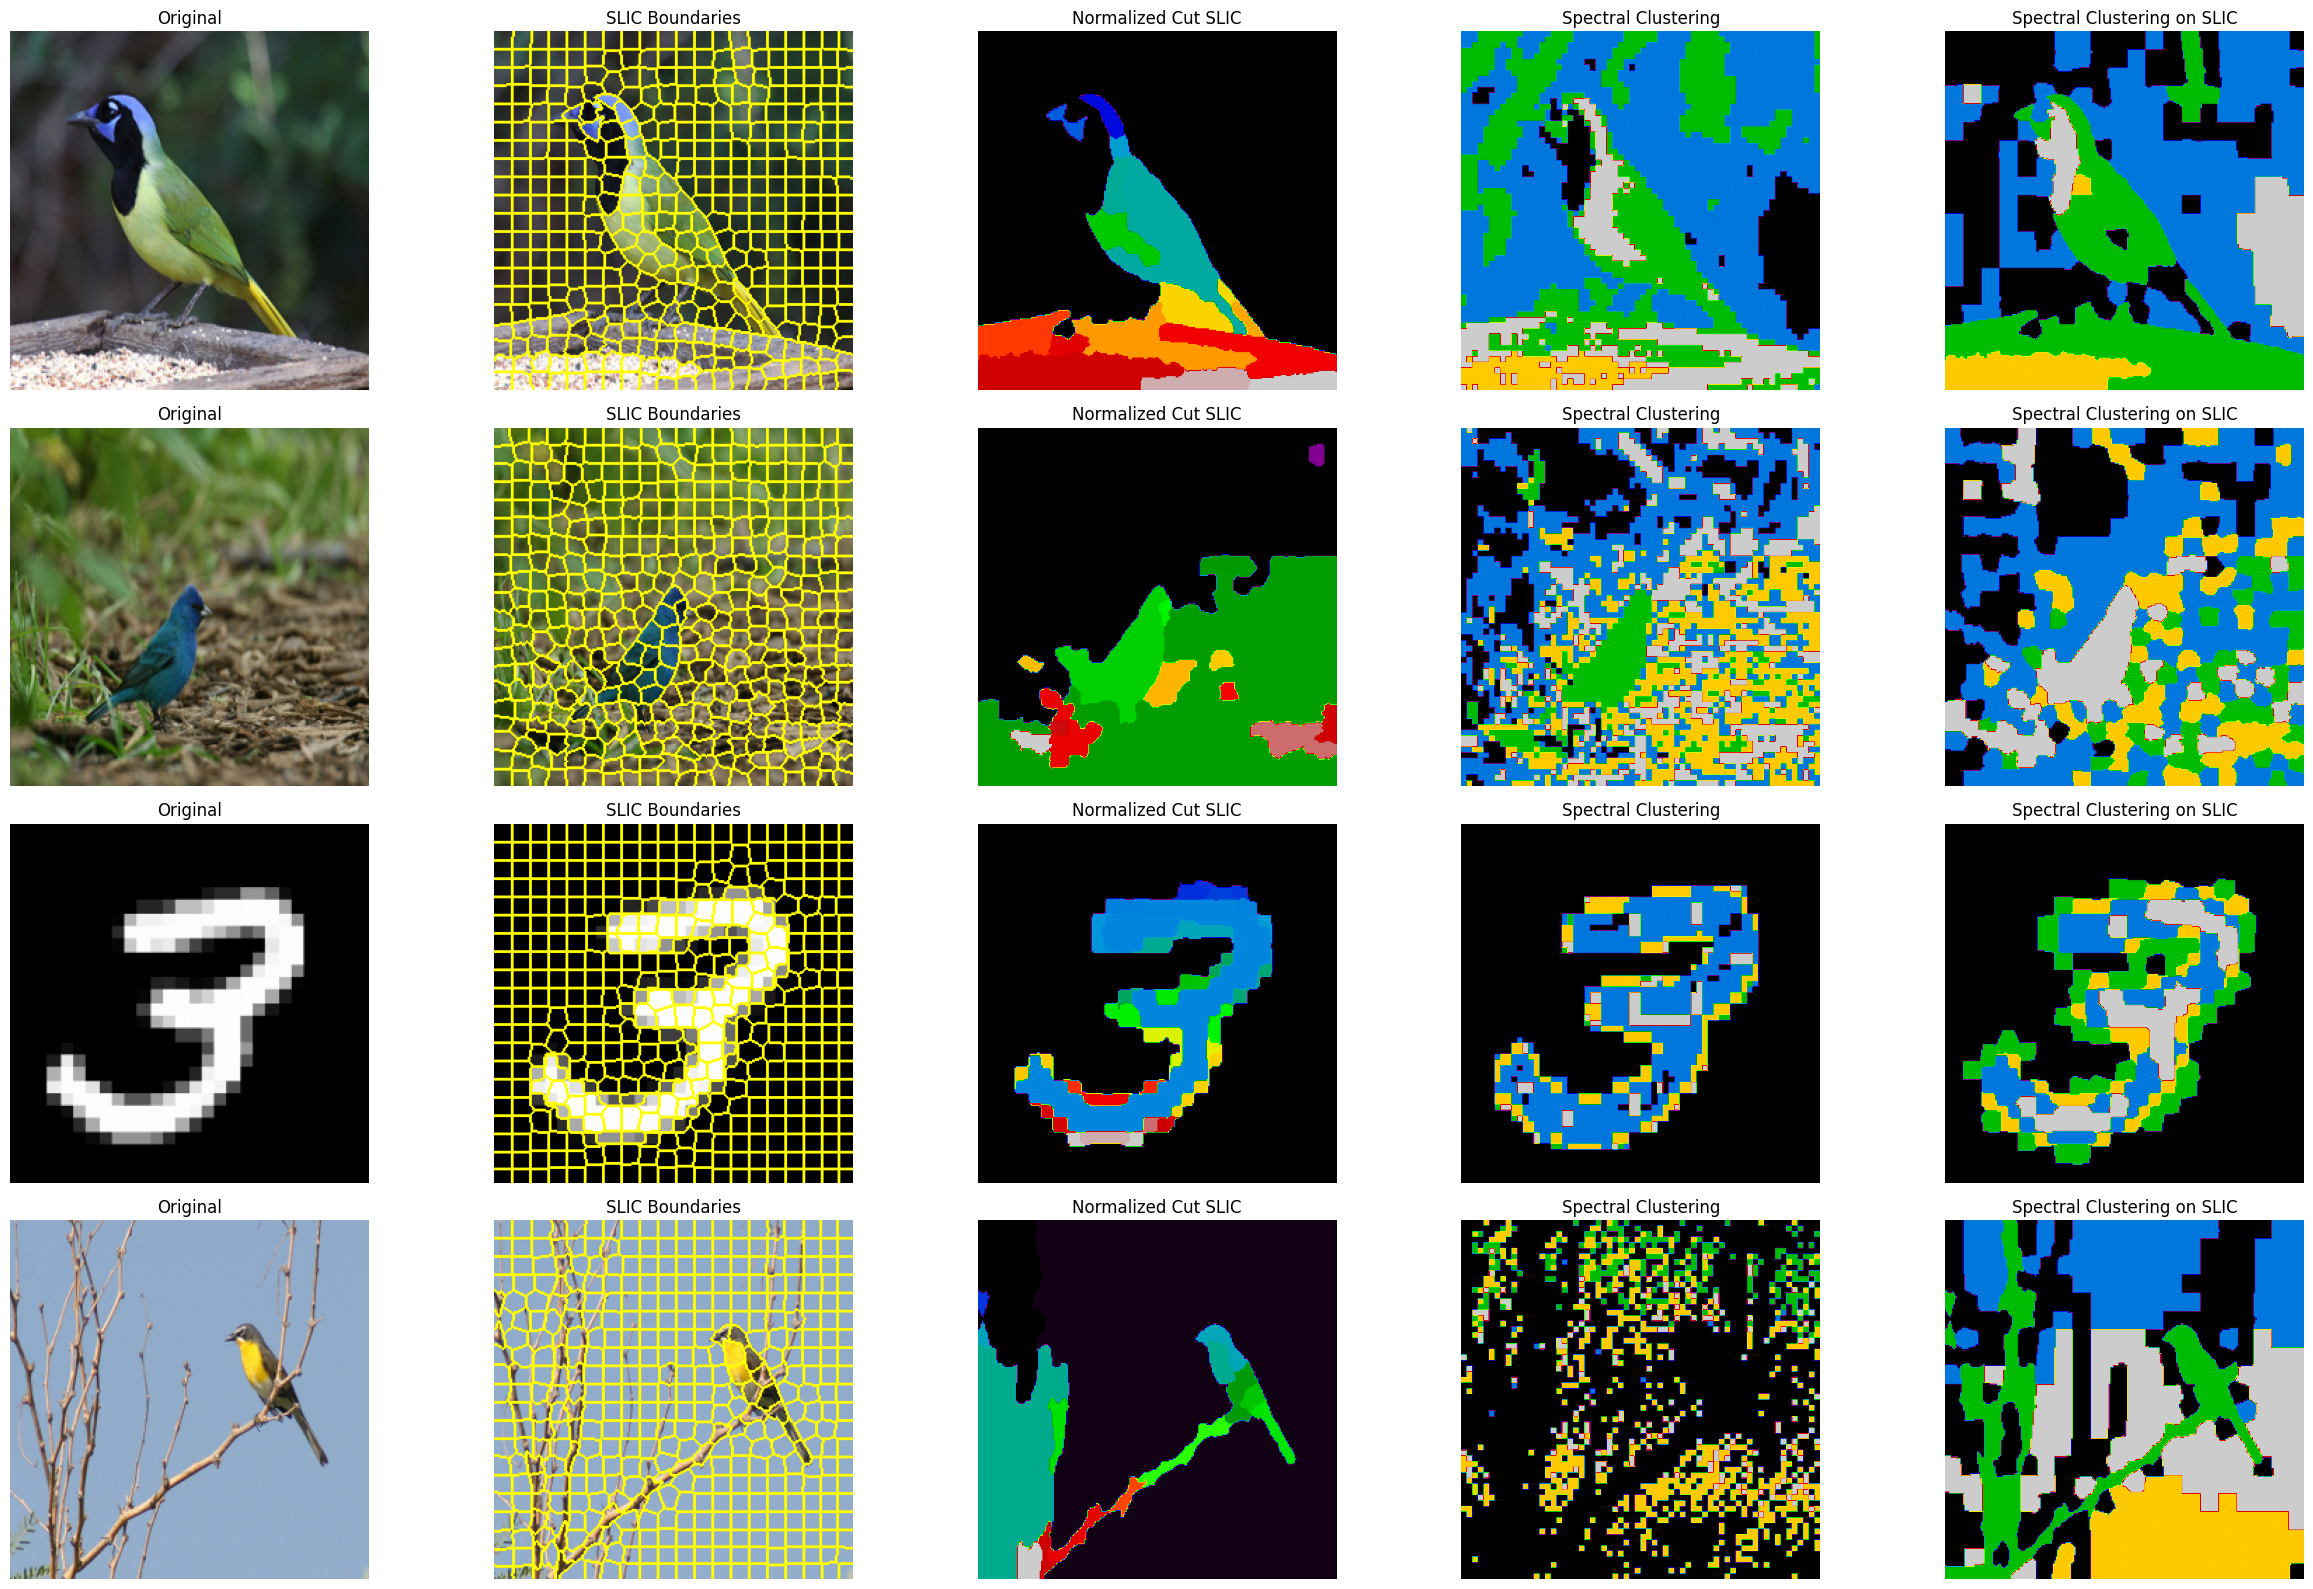

In [18]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, color, graph
from sklearn.cluster import SpectralClustering
from sklearn.feature_extraction import image

# Dossier contenant les images
image_folder  = os.path.join('Deepcut','images', 'single' )

# Récupérer toutes les images
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Charger toutes les images dans une liste
images = [cv2.imread(os.path.join(image_folder, f)) for f in image_files]
fig, ax = plt.subplots(nrows=len(images), ncols=5, figsize=(25, 4*len(images)))

for k in range(len(images)):
    img = images[k]
    # Redimensionner pour uniformité
    res = (256, 256)
    img_resized = cv2.resize(img, res, interpolation=cv2.INTER_AREA)
    
    # Appliquer SLIC
    labels1 = segmentation.slic(img_resized, compactness=40, n_segments=400, sigma=1, start_label=1)
    
    # Appliquer Normalized Cut sur SLIC
    g = graph.rag_mean_color(img_resized, labels1, mode='similarity')
    labels2 = graph.cut_normalized(labels1, g)
    
    # 1. Appliquer Spectral Clustering sur l'image directement
    # Réduire la taille pour rendre le calcul plus rapide
    small_size = (64, 64)
    img_small = cv2.resize(img_resized, small_size, interpolation=cv2.INTER_AREA)
    
    # Convertir l'image en un tableau de pixels pour le clustering
    pixel_samples = np.reshape(img_small, (-1, 3))
    
    # Appliquer le spectral clustering
    n_clusters = 5  # Nombre de clusters à ajuster selon vos besoins
    spectral = SpectralClustering(n_clusters=n_clusters, 
                                 eigen_solver='arpack',
                                 affinity="nearest_neighbors",
                                 assign_labels="kmeans",
                                 random_state=42)
    
    # Réaliser le clustering
    spectral_labels = spectral.fit_predict(pixel_samples)
    
    # Reformater pour l'affichage
    segmented_img = np.reshape(spectral_labels, small_size)
    
    # Redimensionner au format original pour l'affichage
    segmented_img = cv2.resize(segmented_img.astype(float), res, 
                              interpolation=cv2.INTER_NEAREST)
    
    # 2. Appliquer Spectral Clustering sur les régions SLIC
    # Extraire les caractéristiques de chaque segment SLIC
    # Créer un tableau de caractéristiques pour chaque région
    regions = {}
    for i in range(1, np.max(labels1) + 1):
        mask = labels1 == i
        if np.sum(mask) > 0:  # S'assurer que la région existe
            # Calculer la couleur moyenne de la région
            regions[i] = np.mean(img_resized[mask], axis=0)
    
    # Créer une matrice de caractéristiques pour le clustering
    n_regions = len(regions)
    region_features = np.zeros((n_regions, 3))  # 3 pour BGR
    region_indices = list(regions.keys())
    
    for i, region_idx in enumerate(region_indices):
        region_features[i] = regions[region_idx]
    
    # Appliquer le spectral clustering sur les régions SLIC
    # n_sc_clusters = min(n_regions // 5, 10)  # Adapter le nombre de clusters
    # if n_sc_clusters < 2:
    n_sc_clusters = 5  # Au moins 2 clusters
        
    spectral_slic = SpectralClustering(n_clusters=n_sc_clusters,
                                      eigen_solver='arpack',
                                      affinity="nearest_neighbors",
                                      assign_labels="kmeans",
                                      random_state=42)
    
    sc_slic_labels = spectral_slic.fit_predict(region_features)
    
    # Créer l'image segmentée finale
    sc_slic_segmented = np.zeros(labels1.shape, dtype=np.int32)
    for i, region_idx in enumerate(region_indices):
        sc_slic_segmented[labels1 == region_idx] = sc_slic_labels[i]
    
    # Affichage
    ax[k, 0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    ax[k, 0].set_title("Original")
    
    slic_boundaries = segmentation.mark_boundaries(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB), labels1)
    ax[k, 1].imshow(slic_boundaries)
    ax[k, 1].set_title("SLIC Boundaries")
    
    ax[k, 2].imshow(labels2, cmap='nipy_spectral')
    ax[k, 2].set_title("Normalized Cut SLIC")
    
    ax[k, 3].imshow(segmented_img, cmap='nipy_spectral')
    ax[k, 3].set_title("Spectral Clustering")
    
    ax[k, 4].imshow(sc_slic_segmented, cmap='nipy_spectral')
    ax[k, 4].set_title("Spectral Clustering on SLIC")
    
    # Désactiver les axes
    for i in range(5):
        ax[k, i].axis('off')

plt.tight_layout()
plt.show()